**Consumiendo modelo entrenado en Roboflow**

loading Roboflow workspace...
loading Roboflow project...


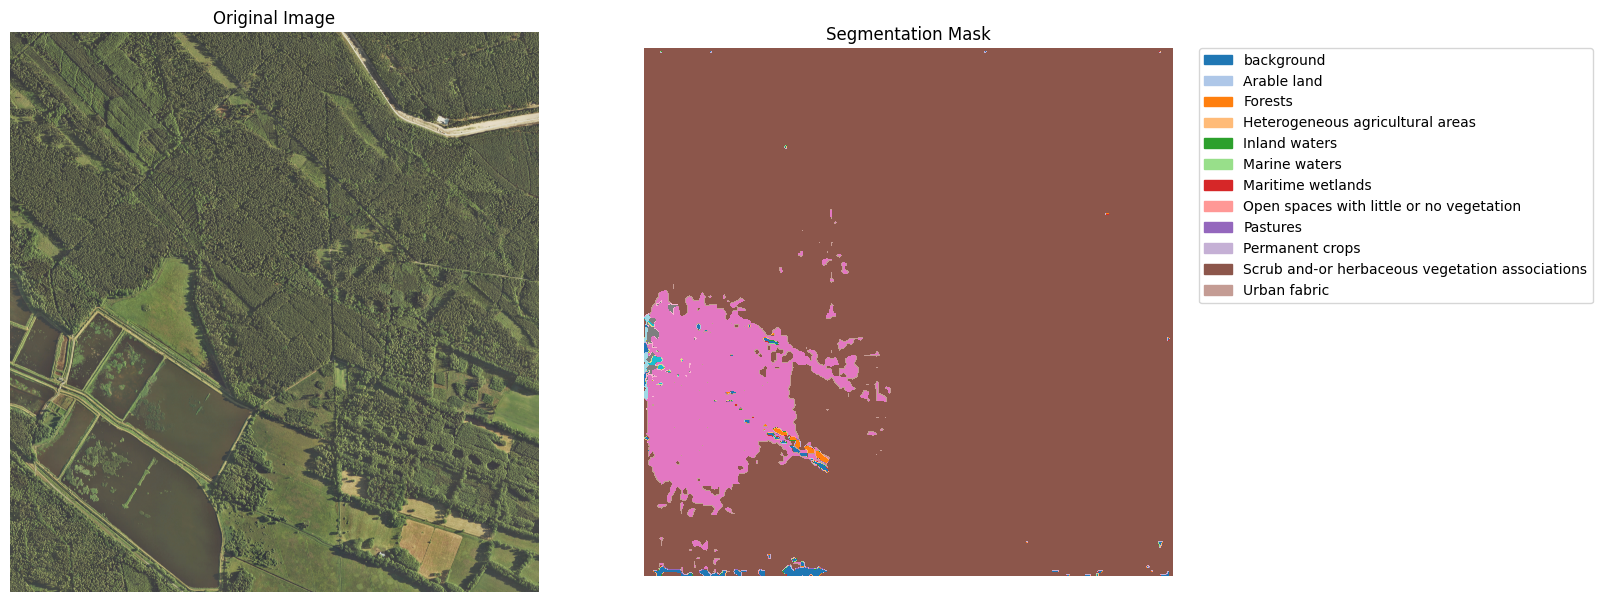

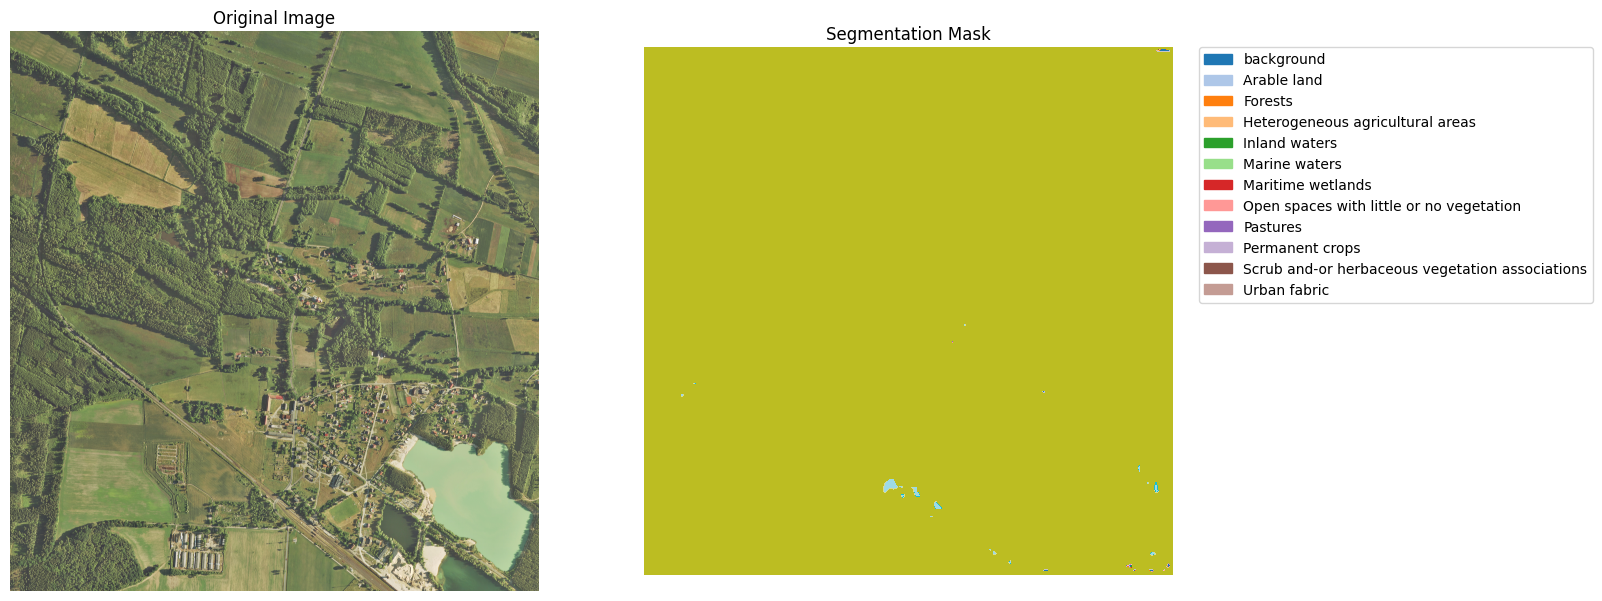

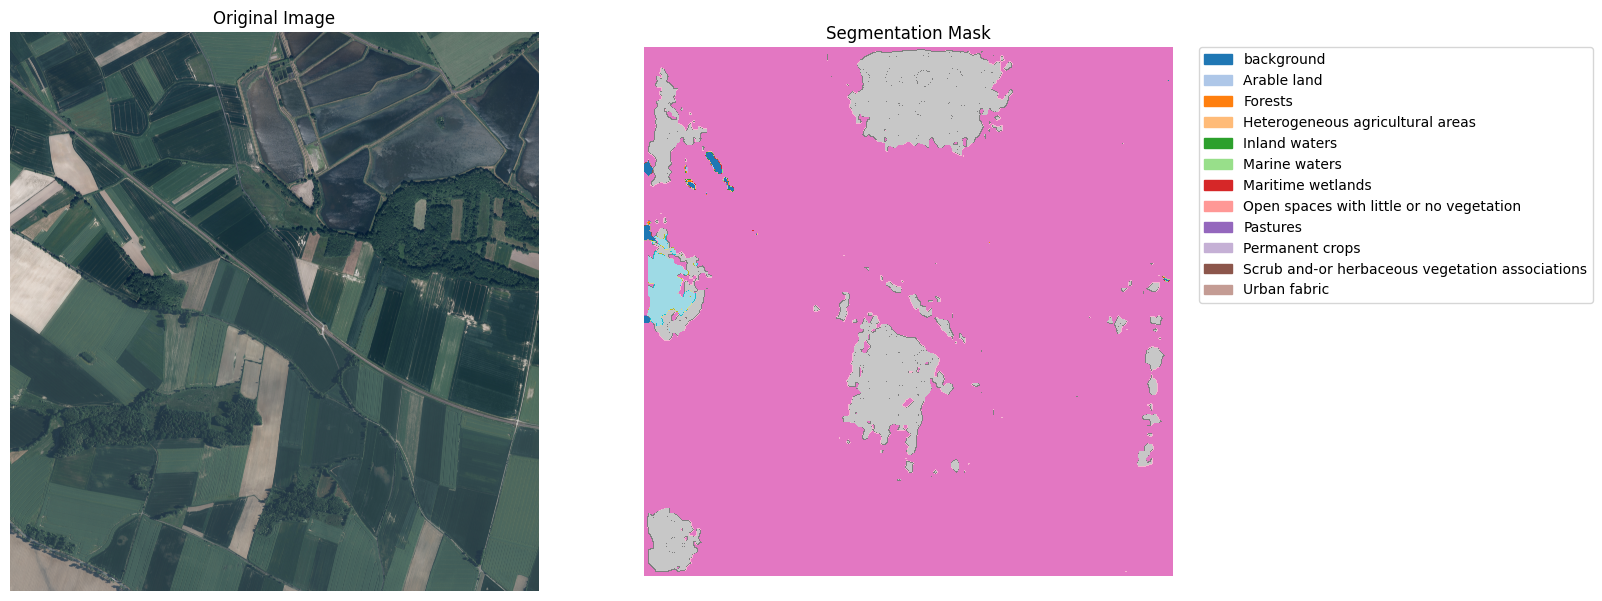

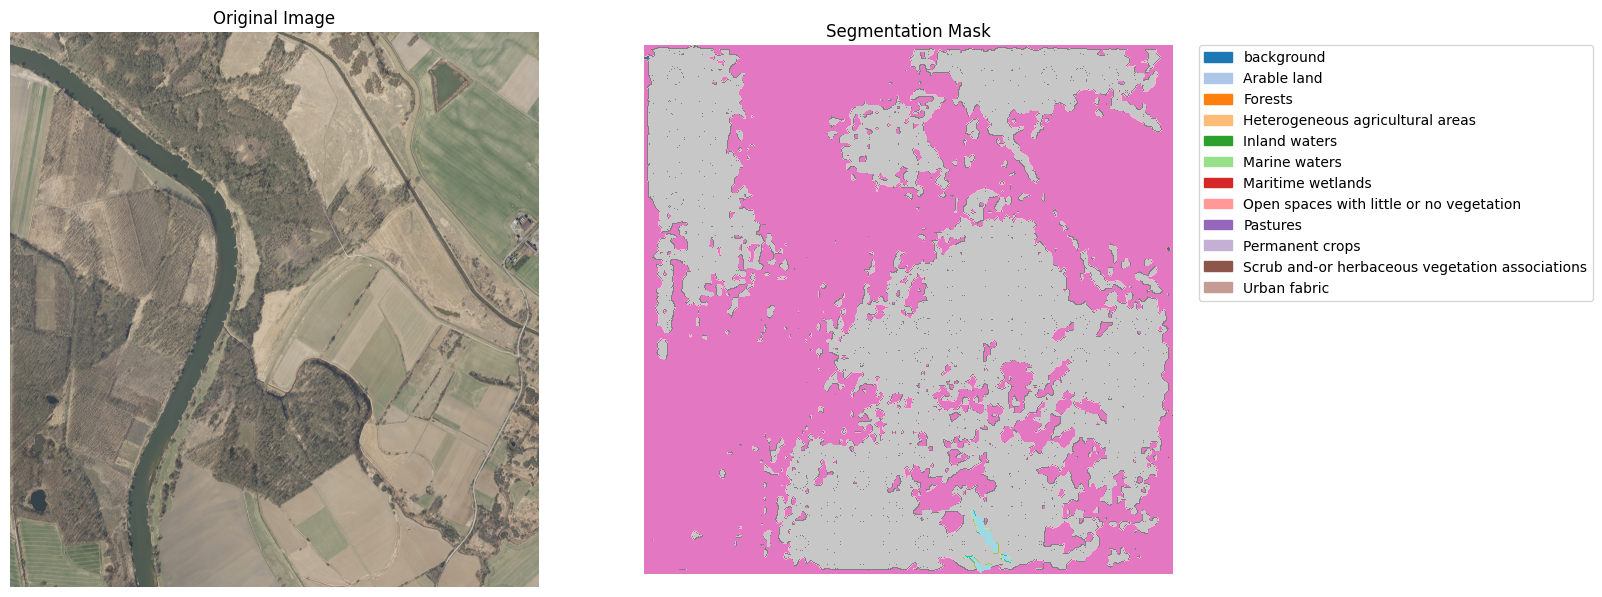

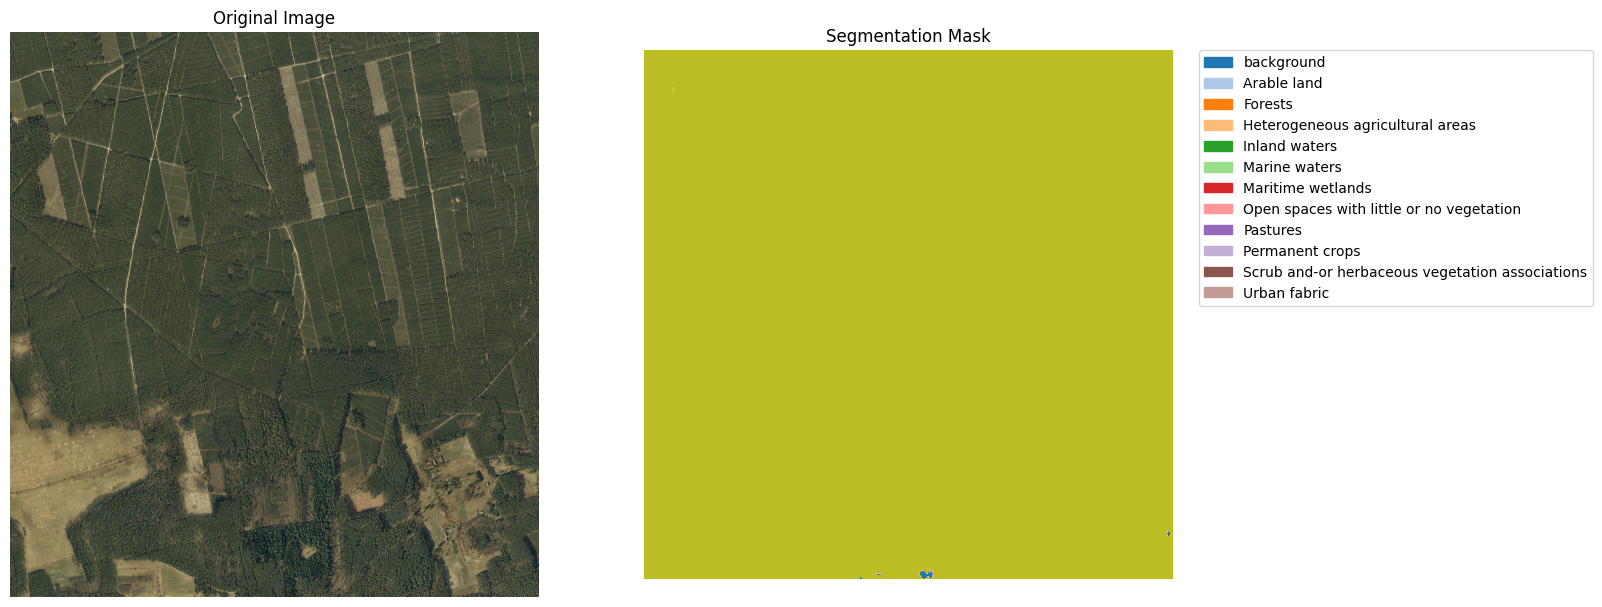

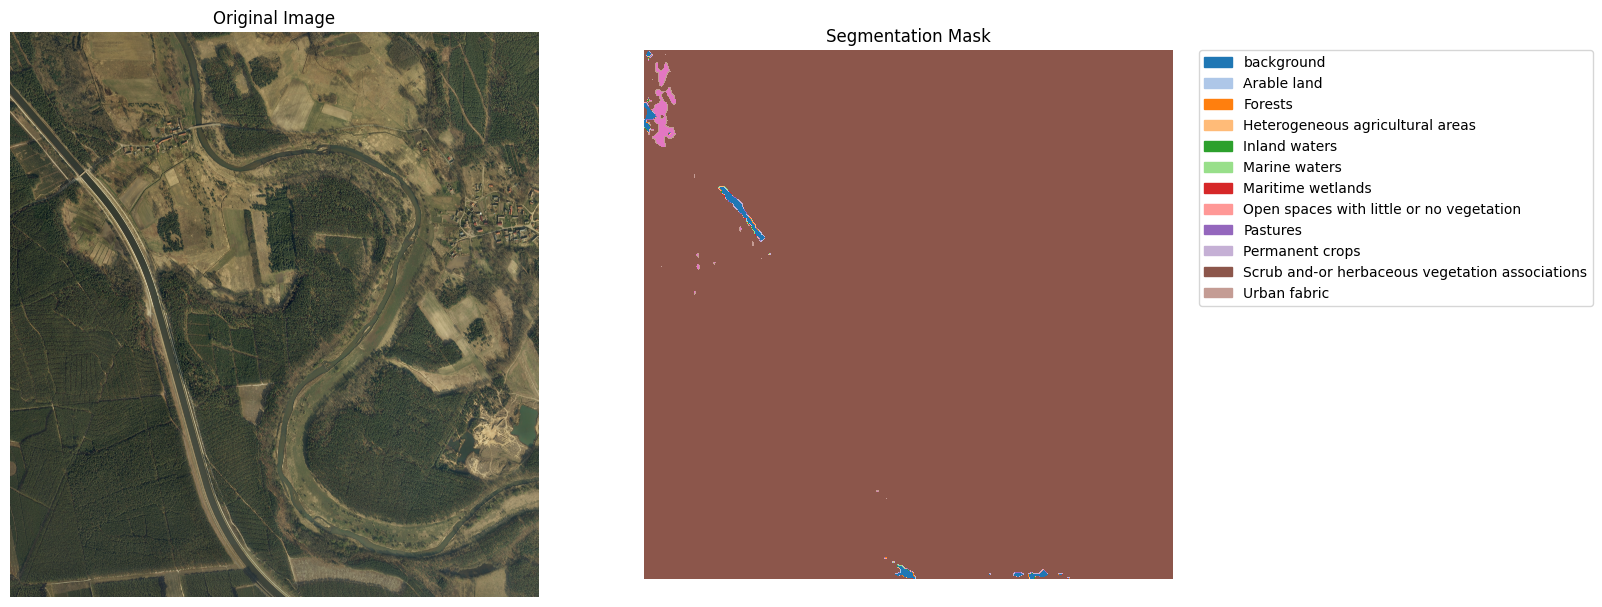

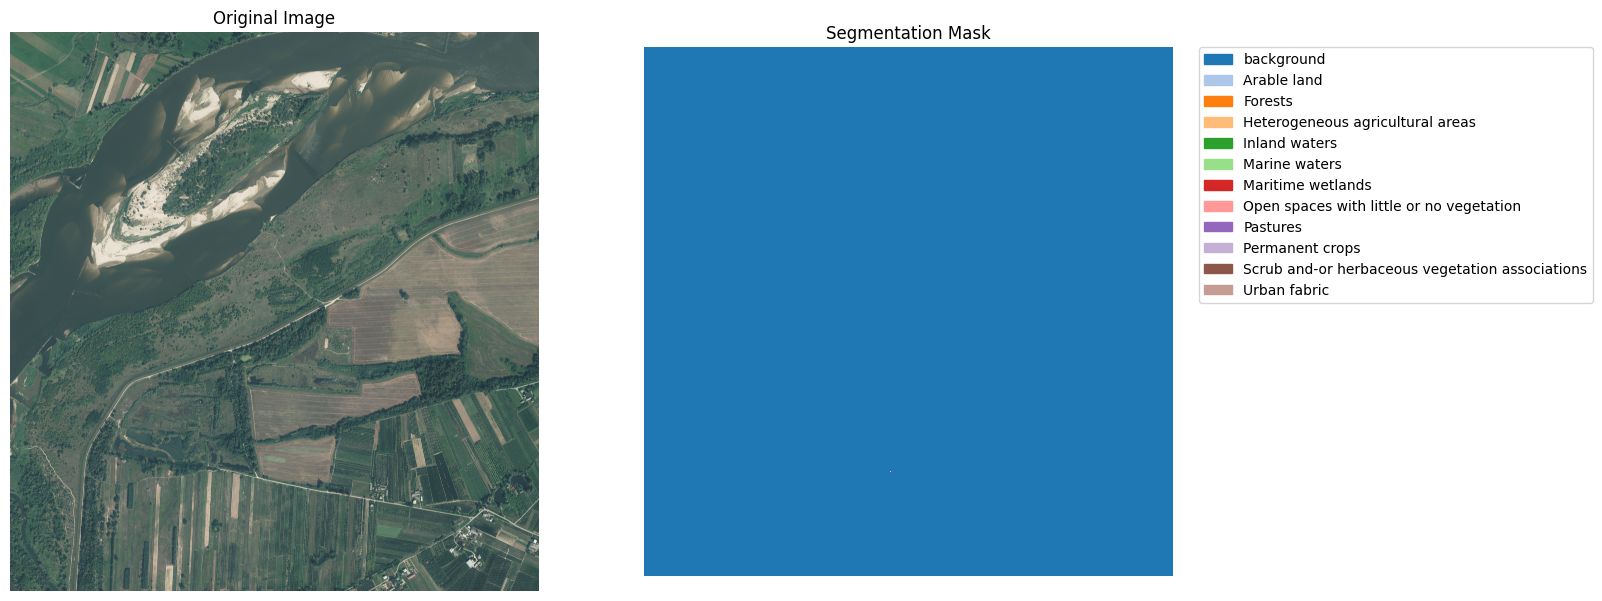

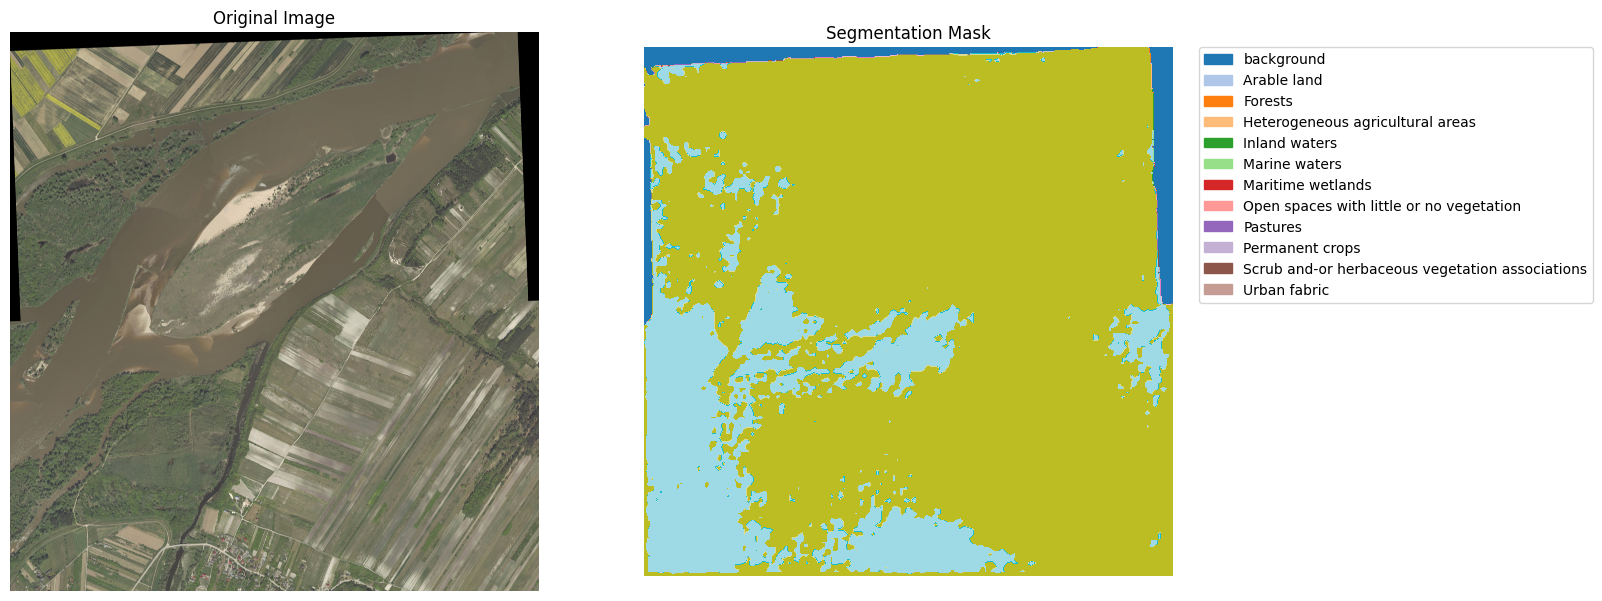

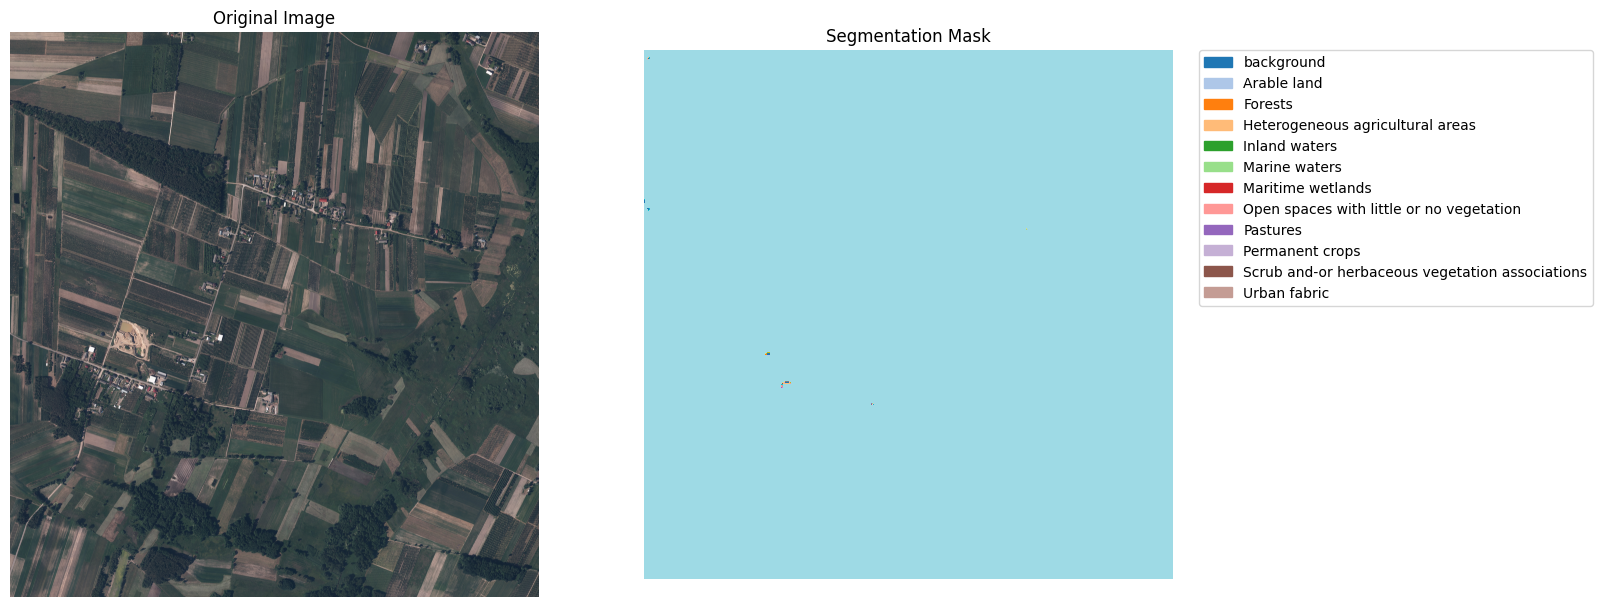

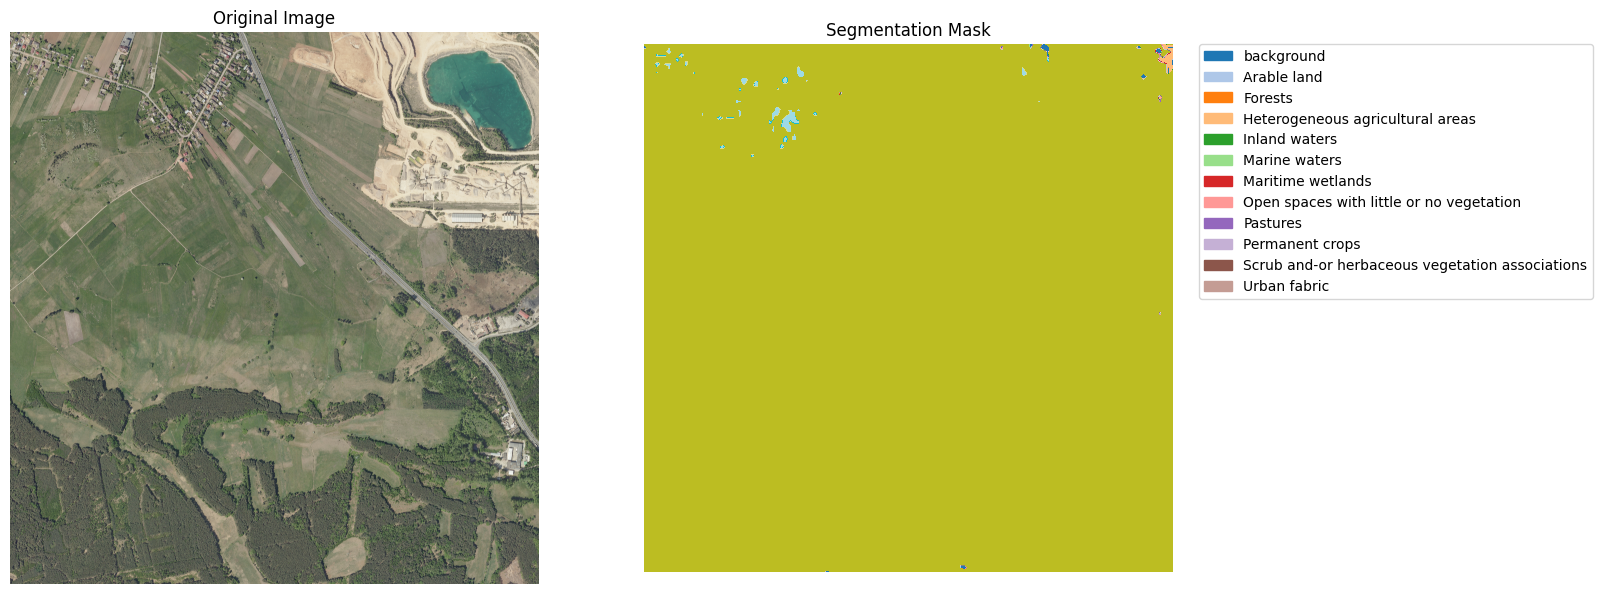

In [1]:
import tkinter as tk
from tkinter import filedialog
from roboflow import Roboflow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import base64
from io import BytesIO
import matplotlib.patches as mpatches
import os
import glob

# Función para decodificar la máscara de segmentación base64
def decode_segmentation_mask(segmentation_mask_base64, width, height):
    segmentation_mask_bytes = base64.b64decode(segmentation_mask_base64)
    segmentation_mask_image = Image.open(BytesIO(segmentation_mask_bytes))
    segmentation_mask = np.array(segmentation_mask_image)
    return segmentation_mask

# Función para cargar y convertir la imagen TIFF seleccionada
def load_and_convert_image():
    # Obtener las primeras 10 imágenes de la carpeta RGB
    image_paths = sorted(glob.glob("../RGB/images/*.tif"))[:10]
    
    for image_path in image_paths:
        # Cargar la imagen TIFF y redimensionarla si es necesario
        tiff_image = Image.open(image_path)
        max_width = 3000
        max_height = 3000
        if tiff_image.width > max_width or tiff_image.height > max_height:
            tiff_image.thumbnail((max_width, max_height))

        # Guardar la imagen redimensionada temporalmente
        temp_file_path = "temp_image.jpg"
        tiff_image.save(temp_file_path)

        # Realizar la predicción
        prediction = model.predict(temp_file_path).json()

        # Eliminar la imagen temporal
        os.remove(temp_file_path)

        # Extraer información de la predicción
        predictions = prediction['predictions'][0]
        segmentation_mask_base64 = predictions['segmentation_mask']
        class_map = predictions['class_map']
        width = int(prediction['image']['width'])
        height = int(prediction['image']['height'])

        # Decodificar la máscara de segmentación
        segmentation_mask = decode_segmentation_mask(segmentation_mask_base64, width, height)

        # Visualizar la imagen original y la máscara de segmentación
        original_image = Image.open(image_path)

        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(segmentation_mask, cmap='tab20')
        plt.title("Segmentation Mask")
        plt.axis('off')

        # Crear la leyenda
        legend_patches = [mpatches.Patch(color=plt.cm.tab20(i), label=class_map[str(i)]) for i in range(len(class_map))]

        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.show()

# Inicializar el cliente de Roboflow
api_key = "uklYhcULuLbwsPeBHY6j"
model_endpoint = "corine-land-cover-segmentation"
version_number = 4

rf = Roboflow(api_key=api_key)
project = rf.workspace().project(model_endpoint)
model = project.version(version_number).model

load_and_convert_image()

